## Spectral Clustering
Steps followed for the Spectral Clustering:
1. Load the similarity matrix and node names (games)
2. Determine the best number of clusters for our dataset by computing the Davies-Bouldien score
3. For that n_clusters, perform clustering and visualize it

In [ ]:
import h5py
import numpy as np
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt

path = "./data/gen/gam_sim_small.h5"

# Load similarity matrix and node names (games)
# with h5py.File(path, "r") as f:
#    print(list(f.keys())) -> ['matrix', 'node_names']

with h5py.File(path, "r") as f:
    S = f["matrix"][:]
    raw_names = np.array(f["node_names"][:])
print("Similarity matrix shape:", S.shape)

# print(type(raw_names[0])) -> <class 'bytes'>
# Decode node names from bytes to strings
names = np.array([name.decode('utf-8') for name in raw_names])

Similarity matrix shape: (593, 593)



Best Davies-Bouldin score: 3.5506652326818227
Corresponding number of clusters: 25


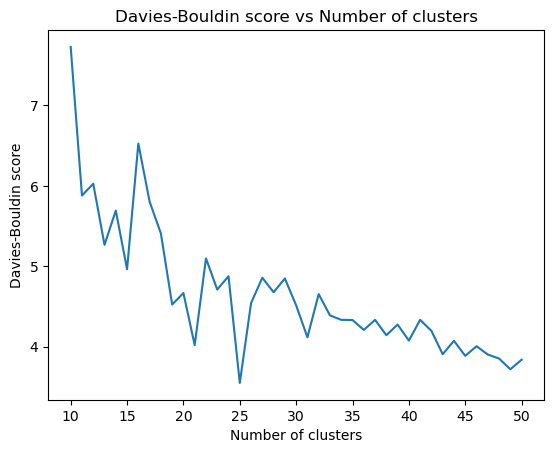

In [57]:
from sklearn.metrics import davies_bouldin_score
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

# Compute Davies-Bouldin scores for different number of clusters to evaluate clustering quality
db_scores = []
for n_clusters in range(10, 51):
    clustering = SpectralClustering(
        n_clusters=n_clusters,
        affinity="precomputed",
        assign_labels="discretize", # see note below
        random_state=42 # for reproducibility
    )
    labels = clustering.fit_predict(S)
    db_score = davies_bouldin_score(S, labels)
    db_scores.append(db_score)
    #print(f"Number of clusters: {n_clusters}, with {db_score} score")

#Best number of clusters based on Davies-Bouldin score
best_db = min(db_scores)
best_clusters = range(10, 51)[db_scores.index(best_db)]
print("\nBest Davies-Bouldin score:", best_db)
print("Corresponding number of clusters:", best_clusters)

# Plot Davies-Bouldin scores
plt.plot(range(10,51), db_scores)
plt.xlabel("Number of clusters")
plt.ylabel("Davies-Bouldin score")
plt.title("Davies-Bouldin score vs Number of clusters")
plt.show()

# NOTE: kmeans gives better DB score than discretize but produces 2 large clusters (~250 games each) and several small ones
# Therefore, we choose discretize with 25 clusters, which provides more interpretable results
# kmeans best DB: 3.0699 (44 clusters), discretize best DB: 3.5506 (25 clusters)


In [66]:
# Spectral clustering for the best_clusters obtained above
n_clusters = best_clusters
clustering = SpectralClustering(
    n_clusters=n_clusters,      
    affinity="precomputed",     
    assign_labels="discretize", 
    random_state=42 
)
labels = clustering.fit_predict(S)
print("Labels:", labels)


Labels: [16 16 23 21 23 21 19 20 21 17 23 16  0 23 21 24 17 19 21 17 21 21 20 21
 19 17 19 22 17 17 23 23 21 20 16  0 23 23 12 17 22 22 17 17 20 22 22 20
 20 23 23 23 12 20 21 21 21 21 21 21 21 21 21 21 21 21 21 21  8 16 16 21
 21 21 17 20 16 21 21 17 16 17 21 21 21 16 16 21 20 22 21 21  8 17 17 17
 20 22 21  3  3 16  8 21 20 16 17 20 16  3 20 21  0 20 20 16 20 21 20 20
 20 16 17 21  2  3 16 20 17  0 16 21 21 20 16 16 16 20 20 16 14 17 17 17
 20 17 17 17 24 17 17  8 17 17 20  8 16 20 24  0 21 24 16 16 24 20 21 21
 16 16 16 23 17 20  8 21 17  0 17 20 16 21  0 20 20 16 16 16 20  8 21 20
 22 20 16 23 20 16 22 10 10 17 17 16 12  7 21 20 17 21 21 16 16 16 20 21
  8  0 17 13 17 16 21 21 24  0 20 20  0 16  0 16 17 16 17  8 21 21 20 20
 20 16 16 16  8  7 20  8  8  8 17 20 24 24 17 10 20 14 16 17 17 16 17 20
  0 21  6 17  6 21  8  9 17 16 21 14 17 16 16 20  0 16 17 21 21 17 21 20
 21 16 13 21 16 17 17  0 17 19 13 13 21 24 16  8 16 16 20  8  0 22 22 21
 21 20 10 16 17 19 19 19 23 20 20 17 17 16 

Cluster sizes:
Cluster 0: 35 games
Cluster 1: 2 games
Cluster 2: 2 games
Cluster 3: 4 games
Cluster 4: 2 games
Cluster 5: 2 games
Cluster 6: 2 games
Cluster 7: 3 games
Cluster 8: 47 games
Cluster 9: 2 games
Cluster 10: 4 games
Cluster 11: 2 games
Cluster 12: 3 games
Cluster 13: 4 games
Cluster 14: 3 games
Cluster 15: 3 games
Cluster 16: 98 games
Cluster 17: 88 games
Cluster 18: 4 games
Cluster 19: 20 games
Cluster 20: 104 games
Cluster 21: 102 games
Cluster 22: 13 games
Cluster 23: 24 games
Cluster 24: 20 games


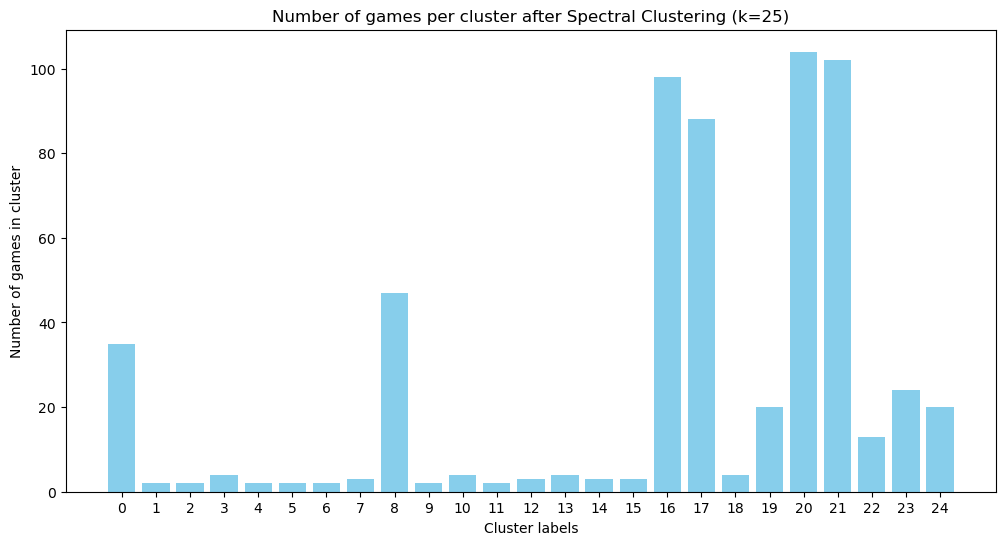

In [78]:
# Count games in each cluster
unique, counts = np.unique(labels, return_counts=True)

print("Cluster sizes:")
for c, cnt in zip(unique, counts):
    print(f"Cluster {c}: {cnt} games")

# Bar plot of cluster sizes
plt.figure(figsize=(12,6))
plt.bar(unique, counts, color='skyblue')
plt.xlabel("Cluster labels")
plt.ylabel("Number of games in cluster")
plt.title("Number of games per cluster after Spectral Clustering (k=25)")
plt.xticks(unique)  
plt.show()

In [ ]:
# Save results to CSV
import pandas as pd

df = pd.DataFrame({"Game": names,"Cluster": labels})
df_sorted = df.sort_values(by="Cluster")
df_sorted.to_csv("./data/gen/spectral_clusters_25.csv", index=False)

## Spectral Clustering done -> Analysis and visualizations:

Find the most representative game of a cluster, considering it as the one that is most similar on average to the rest of games of its cluster (according to the similarity matrix)

In [ ]:
# cluster_games is the list of games in cluster c, S is the similarity matrix, names are the game names

def representative_game(cluster_games, S, names):
    # Indices of the games in S
    idx = [np.where(names == g)[0][0] for g in cluster_games]
    
    # Similarity submatrix restricted to the cluster
    submatrix = S[np.ix_(idx, idx)]
    
    # Average similarity for each game
    mean_sim = submatrix.mean(axis=1)
    
    # Most representative game (highest average similarity)
    most_rep = cluster_games[np.argmax(mean_sim)]
    return most_rep

# Get representative game of each cluster
representatives = {}
for c in range(25):
    representatives[c] = representative_game(clusters[c], S, names)
representatives

{0: 'Disney Villainous: Despicable Plots',
 1: 'Sherlock Aquelarre: El Mercader',
 2: 'Timeline: Inventions',
 3: 'Anno Domini: America',
 4: 'Disney Villainous: Evil Comes Prepared',
 5: 'Funkoverse Strategy Game: Alice in Wonderland 100',
 6: "Rory's Story Cubes: Rescue",
 7: 'Holiday Fluxx',
 8: 'Exceed: Red Horizon – Reese, Heidi, Nehtali, and Vincent',
 9: 'Blanc-Manger Coco',
 10: 'Zaginione Dziedzictwo: Gwiezdne Ostrze',
 11: 'Unlock!: Short Adventures – The Secrets of the Octopus',
 12: 'Stoner Fluxx',
 13: 'Mega Man Pixel Tactics: Mega Man Blue',
 14: 'Timeline: Québec',
 15: 'Sherlock: Propagation',
 16: "Rory's Story Cubes: Clues",
 17: 'Timeline: Polska',
 18: 'Sherlock: Entre tumbas',
 19: 'Something Wild! Villains',
 20: 'Funkoverse Strategy Game: Jaws 100',
 21: 'Anno Domini: Deutschland',
 22: 'Cat-opoly',
 23: 'Fluxx',
 24: 'Pixel Tactics'}

Comprobation of how sparse the similarity matrix is:

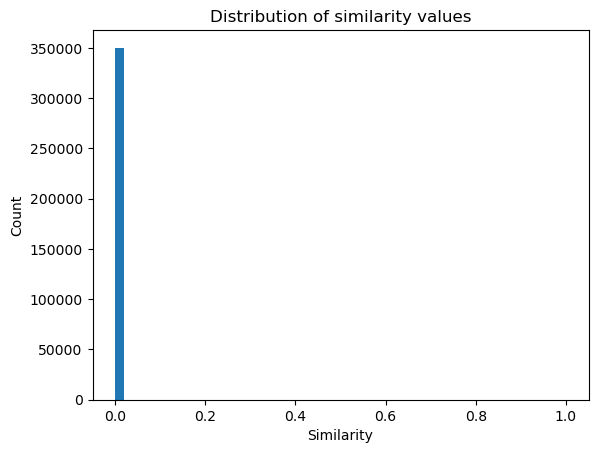

Proportion values < 0.05: 0.9958
Proportion zeros: 0.9958


In [96]:
plt.hist(S.flatten(), bins=50)
plt.title("Distribution of similarity values")
plt.xlabel("Similarity")
plt.ylabel("Count")
plt.show()

threshold = 0.05
sparse_ratio = (S < threshold).mean()
print(f"Proportion values < {threshold}: {sparse_ratio:.4f}")

zero_ratio = (S == 0).mean()
print(f"Proportion zeros: {zero_ratio:.4f}")

## t-SNE:

##### t-SNE on the precomputed distance matrix D=1-S:

This visualization does not provide meaningful information. Since the similarity matrix is very sparse, most values are close to 0, meaning that the distance matrix D=1-S contains many distances close to 1. Then, t-SNE cannot produce meaninful results

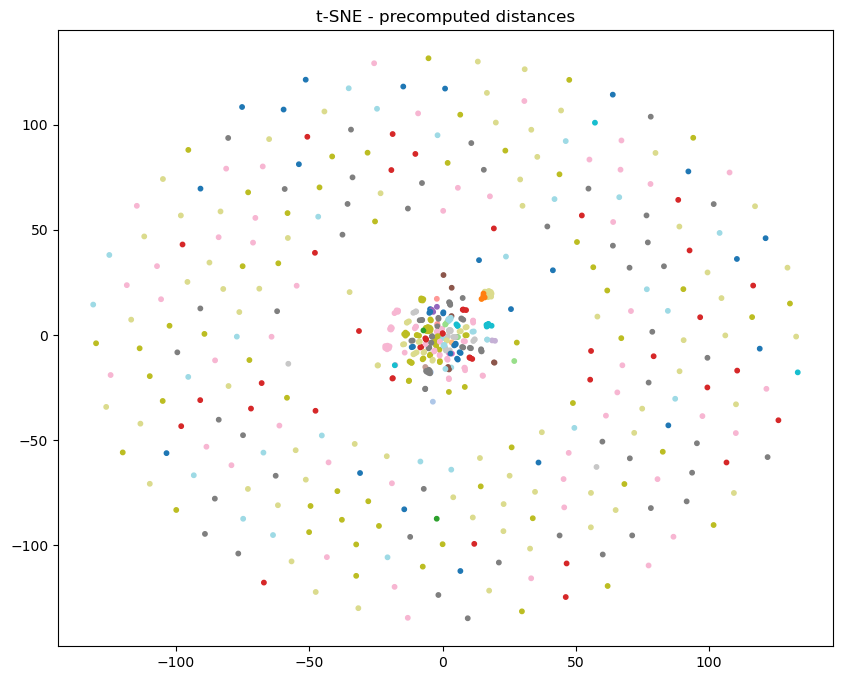

In [ ]:
from sklearn.manifold import TSNE


D = 1 - S  # convert similarity to distance
tsne = TSNE(
    metric="precomputed", 
    init="random", # required for precomputed metric (to avoid error)
    random_state=42
    )
X_2d = tsne.fit_transform(D)

plt.figure(figsize=(10,8))
plt.scatter(X_2d[:,0], X_2d[:,1], c=labels, cmap="tab20", s=10)
plt.title("t-SNE - precomputed distances")
plt.show()


##### t-SNE on the spectral embedding:
The SpectralEmbedding produces a low-dimensional representation of the similarity graph by extracting the main eigenvectors of the Laplacian, which capture the underlying structure of data.
Applying t-SNE on this preserves better local neighborhoods, resulting in more interpretable clusters

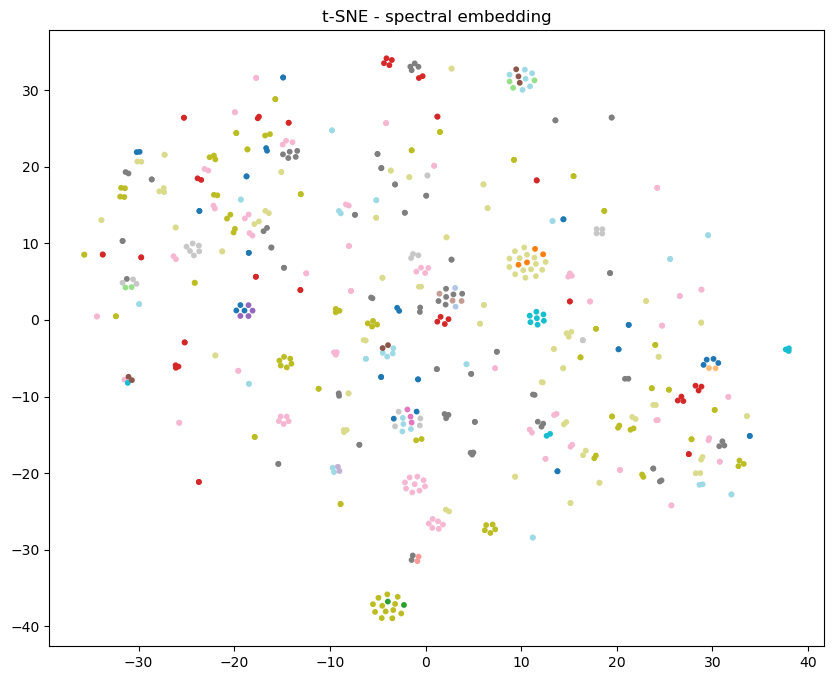

In [ ]:
from sklearn.manifold import SpectralEmbedding, TSNE

# Compute spectral embedding (using 10 dimensions) and apply t-SNE on it
embedding = SpectralEmbedding(
    n_components=10,
    affinity="precomputed"
).fit_transform(S)

X_2d = TSNE(random_state=42).fit_transform(embedding)

plt.figure(figsize=(10,8))
plt.scatter(X_2d[:,0], X_2d[:,1], c=labels, cmap="tab20", s=10)
plt.title("t-SNE - spectral embedding")
plt.show()